# Modelling and Evaluation

## import dependencies

In [68]:
import numpy as np
import pandas as pd
import tensorflow as tf
# import seaborn as sns
from tensorflow import keras
from tensorflow.keras import layers, Input
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, accuracy_score
# from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
# from PIL import Image

import matplotlib.pyplot as plt
import os


## set up directories

In [69]:
# from env import *
# os.chdir(os.environ['WORK_DIR'])

train_dir = '../inputs/work/train'
test_dir = '../inputs/work/test'
val_dir = '../inputs/work/validate'

## Data Preprocessing

In [70]:
image_size = (224, 224)
batch_size = 32
classes = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']

datagen = ImageDataGenerator(preprocessing_function = tf.keras.applications.vgg16.preprocess_input)

# datagen = ImageDataGenerator(
#     zoom_range = 0.1, 
#     rotation_range = 30, 
#     horizontal_flip = True, 
#     vertical_flip = True
# )

# datagen = ImageDataGenerator(
#     rotation_range=20, 
#     width_shift_range=0.10, 
#     height_shift_range=0.10, 
#     shear_range=0.1,
#     zoom_range=0.1,
#     horizontal_flip=True, 
#     vertical_flip=True, 
#     fill_mode='nearest', 
#     rescale=1./255
# )

train_batches = datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    classes=classes
)

test_batches = datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    classes=classes
)

valid_batches = datagen.flow_from_directory(
    val_dir,
    target_size=image_size,
    batch_size=batch_size,
    classes=classes
)

Found 2128 images belonging to 7 classes.
Found 351 images belonging to 7 classes.
Found 177 images belonging to 7 classes.


## Build CNN and Train
* This step can be skipped if a model has been trained previously.

In [71]:
model = Sequential([
    Input(shape=(224,224,3)),
    Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPool2D(pool_size=(2,2), strides=2),
    Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'),
    MaxPool2D(pool_size=(2,2), strides=2),
    Flatten(),
    # Dense(units=32, activation='relu'),
    Dense(units=7, activation='softmax'),
])

model.compile(optimizer= Adam(learning_rate = 0.0005), 
              loss= 'categorical_crossentropy', 
              metrics=['accuracy'])

model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_16 (Conv2D)              │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 224, 224, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 112, 112, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 200704)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 7)              │     1,404,935 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,443,911 (5.51 MB)

 Trainable params: 1,443,783 (5.51 MB)

 Non-trainable params: 128 (512.00 B)

Load previous model if it exists

In [72]:
if os.path.exists('outputs/model.keras'):
    model = load_model('outputs/model.keras')
    print('---> Previous Model loaded')
    model.summary()
else: 
    print('---> Training new model')


---> Previous Model loaded


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_14 (Conv2D)              │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 224, 224, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 112, 112, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 200704)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 7)              │     1,404,935 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,331,479 (16.52 MB)

 Trainable params: 1,443,783 (5.51 MB)

 Non-trainable params: 128 (512.00 B)

 Optimizer params: 2,887,568 (11.02 MB)

Training step, this is time consuming. The trained model is saved, so predictions can be tested without retraining the model and training can be resumed if desired. 

In [73]:
model.fit(
    x=train_batches, 
    validation_data=valid_batches,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5)],
    epochs=50,
    verbose=1)
model.save('outputs/model.keras')

Epoch 1/50


/home/pxp/anaconda3/envs/ten3/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


67/67 ━━━━━━━━━━━━━━━━━━━━ 113s 2s/step - accuracy: 0.5378 - loss: 2.3148 - val_accuracy: 0.3842 - val_loss: 4.3443
Epoch 2/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 111s 2s/step - accuracy: 0.7089 - loss: 0.9162 - val_accuracy: 0.5141 - val_loss: 1.7398
Epoch 3/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 110s 2s/step - accuracy: 0.8942 - loss: 0.3143 - val_accuracy: 0.6102 - val_loss: 1.2145
Epoch 4/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 109s 2s/step - accuracy: 0.9604 - loss: 0.1423 - val_accuracy: 0.6102 - val_loss: 1.3802
Epoch 5/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 110s 2s/step - accuracy: 0.9934 - loss: 0.0471 - val_accuracy: 0.6554 - val_loss: 1.3286
Epoch 6/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 112s 2s/step - accuracy: 0.9963 - loss: 0.0231 - val_accuracy: 0.6610 - val_loss: 1.3170
Epoch 7/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 111s 2s/step - accuracy: 0.9986 - loss: 0.0192 - val_accuracy: 0.6554 - val_loss: 1.3365
Epoch 8/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 112s 2s/step - accuracy: 1.0000 - loss: 0.0077 - val_accuracy: 0.6723 - val_loss: 1.

### Model Evaluation

This step requires training the model, or there will be no history data.  

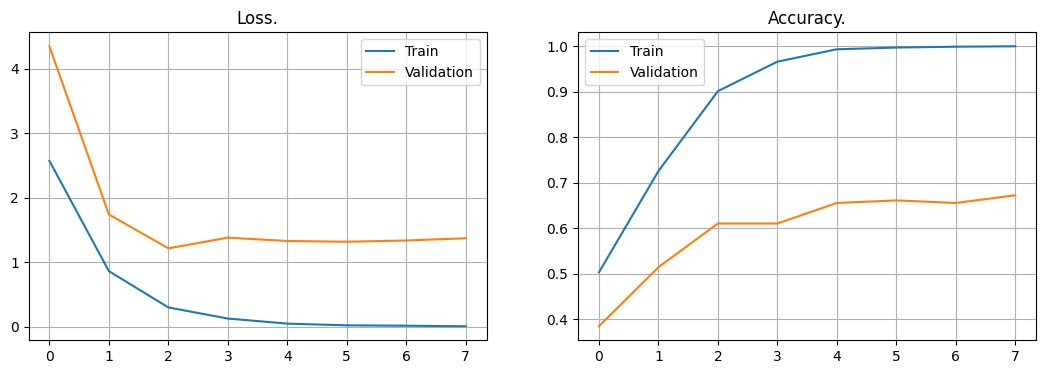

In [74]:
metrics = model.history.history

train_loss = metrics["loss"]
train_accuracy = metrics["accuracy"]

val_loss = metrics["val_loss"]
val_accuracy = metrics["val_accuracy"]

plt.figure(figsize = (13,4))
plt.subplot(1,2,1)
plt.title("Loss.")
plt.plot(train_loss, label = "Train");
plt.plot(val_loss, label = "Validation");
plt.grid(True)
plt.legend(loc = "best");

plt.subplot(1,2,2)
plt.title("Accuracy.")
plt.plot(train_accuracy, label = "Train");
plt.plot(val_accuracy, label = "Validation");
plt.grid(True)
plt.legend(loc = "best");

## Model Prediction

In [75]:
model = load_model('outputs/model.keras')

In [76]:
image_size = (224, 224)
batch_size = 32
classes = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']

datagen = ImageDataGenerator(preprocessing_function = tf.keras.applications.vgg16.preprocess_input)

test_batches = datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    classes=classes
)


Found 351 images belonging to 7 classes.


In [77]:
batch = test_batches
predictions = model.predict(x=batch, verbose=0)
true_labels = batch.classes
predicted_labels = np.argmax(predictions, axis=1)
class_names = {v: k for k, v in batch.class_indices.items()}
report = classification_report(true_labels, predicted_labels, target_names=class_names.values())
print(report)

              precision    recall  f1-score   support

       akiec       0.20      0.25      0.22        60
         bcc       0.22      0.22      0.22        60
         bkl       0.23      0.17      0.19        60
          df       0.05      0.04      0.05        23
         mel       0.19      0.25      0.22        60
          nv       0.12      0.10      0.11        60
        vasc       0.08      0.07      0.07        28

    accuracy                           0.18       351
   macro avg       0.16      0.16      0.15       351
weighted avg       0.17      0.18      0.17       351



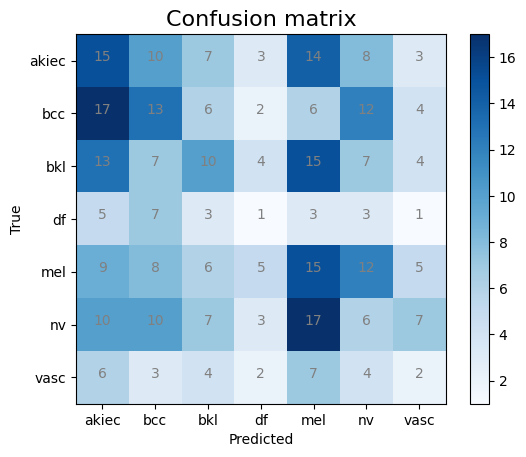

In [78]:
cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=-1))
# classes = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion matrix', fontsize=16)
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)
plt.ylabel('True')
plt.xlabel('Predicted')

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], horizontalalignment="center", color="gray")

In [79]:
# import time 
# os.system(f"curl -d 'training done {time.ctime()}' http://52.56.34.125/test")